# Linear Regression
In this tutorial, we will show how to perform a simple linear regression. We will use synthetic data for which we know the true parameters. We will then fit a linear model to this data and see if we can recover the true parameters.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.style.use("presentation")
jax.config.update("jax_enable_x64", True)

## 1. Generate synthetic data
The data contain pairs of $(x, y)$ values, where $x$ is the 1-d feature and $y$ is the target. The underlying model is $y = \theta_0 + \theta_1 x + \epsilon$, where $\epsilon$ is Gaussian noise. We set $\theta_0 = 5.7$, $\theta_1 = 2.5$, and the standard deviation of $\epsilon$ to 2.0. We generate 100 synthetic data points based on this model.

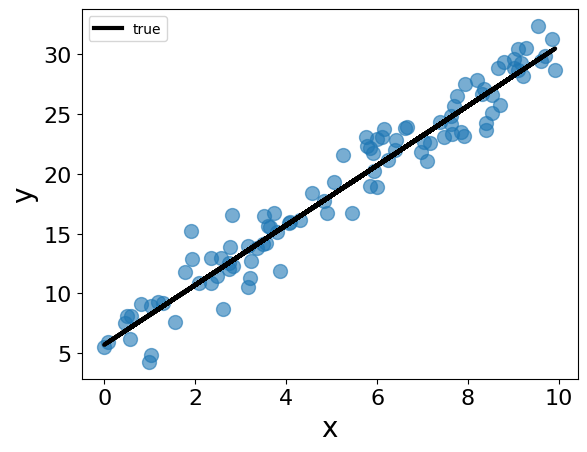

In [2]:
## true parameters
theta_1 = 2.5
theta_0 = 5.7

## x is the feature
key = jr.PRNGKey(0)
subkey, key = jr.split(key)
x = jr.uniform(subkey, shape=(100,), minval=0, maxval=10)

## y is the response
subkey, key = jr.split(key)
y = theta_0 + theta_1 * x + jr.normal(subkey, shape=x.shape) * 2.0

## plot the data
fig = plt.figure()
plt.clf()
plt.plot(x, y, "o", alpha=0.6)
plt.plot(x, theta_0 + theta_1 * x, '-', label="true", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Turn data and parameters into matrix/vector form

In [3]:
theta = jnp.array([theta_0, theta_1])
x = jnp.stack([jnp.ones_like(x), x], axis=1)
print("shape of theta: ", theta.shape)
print("shape of x: ", x.shape)

shape of theta:  (2,)
shape of x:  (100, 2)


## 2. Fit the linear model
We will fit the linear model using both the analytical solution and the gradient descent algorithm. We will then compare the estimated parameters with the true parameters.
### Analytical solution
Although it is attempting to directly use the formula: $\theta = (X^T X)^{-1} X^T y$ to compute the analytical solution, it is not recommended because it requires inverting a matrix, which could be numerically unstable. Instead, we can compute the solution using the QR decomposition of $X$.

In [11]:
## use the formula directly
theta_naive = jnp.linalg.inv(x.T @ x) @ x.T @ y

## use the QR decomposition
Q, R = jnp.linalg.qr(x)
theta_qr = jax.scipy.linalg.solve_triangular(R, Q.T @ y)

## although the two methods provide the same result here, the method using QR decomposition is numerically more stable and should be preferred
print("theta_true:", theta) 
print("theta_naive:", theta_naive)
print("theta_qr:", theta_qr)

theta_true: [5.7 2.5]
theta_naive: [5.76809547 2.51084153]
theta_qr: [5.76809547 2.51084153]


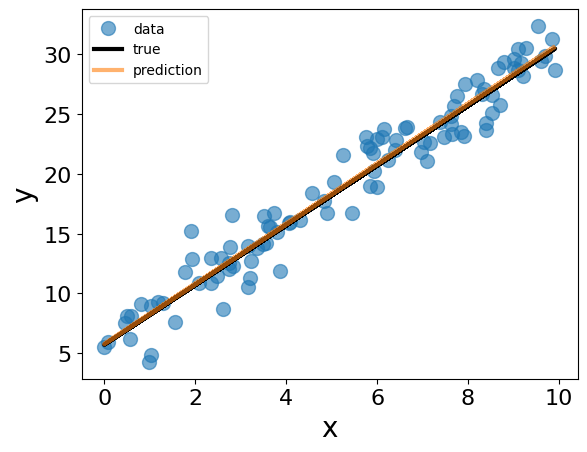

In [5]:
## make predictions using the estimated parameters
y_pred = jnp.matmul(x, theta_qr)

fig = plt.figure()
plt.clf()
plt.plot(x[:,1], y, "o", label="data", alpha=0.6)
plt.plot(x[:,1], theta_0 + theta_1 * x[:,1], '-', label="true", color="black")
plt.plot(x[:,1], y_pred, label="prediction", alpha=0.6) 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Gradient descent
First, we provide a simple implementation of the gradient descent algorithm for fitting the linear model. In the implementation, we use a fixed learning rate.

In [6]:
## define the loss function
def loss_fn(theta, x, y):
    return 0.5*jnp.mean((jnp.matmul(x, theta) - y) ** 2)

## function to compute the gradient of the loss function
grad_fn = jax.grad(loss_fn, argnums=0)

## train the model
step_size = 0.01

## stopping criteria
max_iter = 10_000
g_tol = 1e-6
f_tol = 1e-8

theta_gd = jnp.array([0.0, 0.0])
loss = loss_fn(theta_gd, x, y)

for idx_iter in range(max_iter):
    gradient = grad_fn(theta_gd, x, y)
    if jnp.all(jnp.abs(gradient) < g_tol):
        break

    theta_gd -= step_size * gradient
    loss_new = loss_fn(theta_gd, x, y)

    if jnp.abs((loss - loss_new)/max(jnp.abs(loss), jnp.abs(loss_new), 1)) < f_tol:
        break

    loss = loss_new

    if idx_iter % 100 == 0:
        print(
            f"Loss at step {idx_iter:>3}: {loss:>6.2f}, theta:", theta_gd, "gradident:", gradient
        )

Loss at step   0:  85.97, theta: [0.18974219 1.20315769] gradident: [ -18.97421894 -120.31576877]
Loss at step 100:   3.43, theta: [1.55316878 3.13334832] gradident: [-0.94286931  0.13925332]
Loss at step 200:   2.70, theta: [2.39718003 3.00869544] gradident: [-0.75406595  0.11136876]
Loss at step 300:   2.24, theta: [3.0721836  2.90900348] gradident: [-0.60306922  0.0890679 ]
Loss at step 400:   1.94, theta: [3.61202215 2.82927418] gradident: [-0.48230859  0.07123264]
Loss at step 500:   1.75, theta: [4.0437616  2.76551014] gradident: [-0.38572948  0.05696878]
Loss at step 600:   1.62, theta: [4.38904808 2.71451443] gradident: [-0.3084897   0.04556116]
Loss at step 700:   1.55, theta: [4.66519321 2.67373028] gradident: [-0.24671667  0.03643784]
Loss at step 800:   1.50, theta: [4.88604211 2.64111288] gradident: [-0.19731329  0.0291414 ]
Loss at step 900:   1.46, theta: [5.06266747 2.6150269 ] gradident: [-0.1578026   0.02330603]
Loss at step 1000:   1.44, theta: [5.20392477 2.59416447

In [7]:
print("theta_true:", theta)
print("theta_gd:", theta_gd)

theta_true: [5.7 2.5]
theta_gd: [5.76285527 2.51161546]


In practice, we rarely write our own optimization algorithm. Instead, we use more advanced implementations offered by various libraries. In this tutorial, we will use the `LBFGS` algorithm provided by the `scipy.optimize` library. It is more efficient and does not require specifying a learning rate. All we need to do is to provide a function that computes the loss and its gradient.

In [8]:
from scipy import optimize
import numpy as np 

options = {"disp": 1, "gtol": 1e-8}
f = jax.value_and_grad(loss_fn, argnums=0)

def func(theta):
    return [np.array(r) for r in f(theta, x, y)]

theta_init = jnp.array([0.0, 0.0])
res = optimize.minimize(
    func,
    theta_init,
    jac=True,
    method="L-BFGS-B",
    tol=1e-12,
    options=options,
)
print(res)


  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.4068179203820095
        x: [ 5.768e+00  2.511e+00]
      nit: 6
      jac: [ 3.079e-09  4.877e-09]
     nfev: 9
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [9]:
theta_bfgs = res.x
print("theta_true:", theta)
print("theta_bfgs:", theta_bfgs)

theta_true: [5.7 2.5]
theta_bfgs: [5.76809548 2.51084153]
